## multi-to-multi step forecast

In [1]:
import os
import math
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

filename = 'shampoo-three-year.csv'

Using TensorFlow backend.


#### preprocessing for time-step forecasting

In [2]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = int(x_data.shape[0] * (1 - test_size))
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""
# def split_dataset():
    

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series, x_steps=1, y_steps=1, test_size=0.4)
# transform original value to diff value
diff_series = difference(origin_series, 1)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, x_steps=1, y_steps=1, test_size=0.4)

In [3]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (21, 1)
training Y data shape: (21, 1)
test X data shape: (14, 1)
test Y data shape: (14, 1)


In [4]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (20, 1)
training Y data shape: (20, 1)
test X data shape: (14, 1)
test Y data shape: (14, 1)


In [5]:
# data reshape : for trim batch size (train, predict in Neural Networks)
# x_train = x_train[:16, :]
# y_train = y_train[:16, :]
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [6]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (20, 1)
training Y data shape: (20, 1)
test X data shape: (12, 1)
test Y data shape: (12, 1)


#### change shape for (LSTM or RNN)

In [7]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 1
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [8]:
num_epochs = 500
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
20/20 [==============================] - 0s 19ms/step - loss: 0.1517
epochs : 1
Epoch 1/1
20/20 [==============================] - 0s 640us/step - loss: 0.1425
epochs : 2
Epoch 1/1
20/20 [==============================] - 0s 969us/step - loss: 0.1337
epochs : 3
Epoch 1/1
20/20 [==============================] - 0s 894us/step - loss: 0.1253
epochs : 4
Epoch 1/1
20/20 [==============================] - 0s 1ms/step - loss: 0.1175
epochs : 5
Epoch 1/1
20/20 [==============================] - 0s 872us/step - loss: 0.1101
epochs : 6
Epoch 1/1
20/20 [==============================] - 0s 1ms/step - loss: 0.1032
epochs : 7
Epoch 1/1
20/20 [==============================] - 0s 770us/step - loss: 0.0967
epochs : 8
Epoch 1/1
20/20 [==============================] - 0s 1ms/step - loss: 0.0908
epochs : 9
Epoch 1/1
20/20 [==============================] - 0s 872us/step - loss: 0.0853
epochs : 10
Epoch 1/1
20/20 [==============================] - 0s 969us/step - loss: 0.0802
epoch

20/20 [==============================] - 0s 689us/step - loss: 0.0336
epochs : 90
Epoch 1/1
20/20 [==============================] - 0s 837us/step - loss: 0.0335
epochs : 91
Epoch 1/1
20/20 [==============================] - 0s 727us/step - loss: 0.0334
epochs : 92
Epoch 1/1
20/20 [==============================] - 0s 701us/step - loss: 0.0333
epochs : 93
Epoch 1/1
20/20 [==============================] - 0s 969us/step - loss: 0.0332
epochs : 94
Epoch 1/1
20/20 [==============================] - 0s 1ms/step - loss: 0.0331
epochs : 95
Epoch 1/1
20/20 [==============================] - 0s 1ms/step - loss: 0.0330
epochs : 96
Epoch 1/1
20/20 [==============================] - 0s 1ms/step - loss: 0.0329
epochs : 97
Epoch 1/1
20/20 [==============================] - 0s 955us/step - loss: 0.0328
epochs : 98
Epoch 1/1
20/20 [==============================] - 0s 988us/step - loss: 0.0327
epochs : 99
Epoch 1/1
20/20 [==============================] - 0s 912us/step - loss: 0.0326
epochs : 100
Epo

20/20 [==============================] - 0s 699us/step - loss: 0.0265
epochs : 178
Epoch 1/1
20/20 [==============================] - 0s 891us/step - loss: 0.0264
epochs : 179
Epoch 1/1
20/20 [==============================] - 0s 750us/step - loss: 0.0264
epochs : 180
Epoch 1/1
20/20 [==============================] - 0s 828us/step - loss: 0.0263
epochs : 181
Epoch 1/1
20/20 [==============================] - 0s 808us/step - loss: 0.0263
epochs : 182
Epoch 1/1
20/20 [==============================] - 0s 864us/step - loss: 0.0262
epochs : 183
Epoch 1/1
20/20 [==============================] - 0s 836us/step - loss: 0.0262
epochs : 184
Epoch 1/1
20/20 [==============================] - 0s 821us/step - loss: 0.0262
epochs : 185
Epoch 1/1
20/20 [==============================] - 0s 760us/step - loss: 0.0261
epochs : 186
Epoch 1/1
20/20 [==============================] - 0s 838us/step - loss: 0.0261
epochs : 187
Epoch 1/1
20/20 [==============================] - 0s 791us/step - loss: 0.0260


20/20 [==============================] - 0s 802us/step - loss: 0.0240
epochs : 266
Epoch 1/1
20/20 [==============================] - 0s 720us/step - loss: 0.0240
epochs : 267
Epoch 1/1
20/20 [==============================] - 0s 826us/step - loss: 0.0240
epochs : 268
Epoch 1/1
20/20 [==============================] - 0s 652us/step - loss: 0.0240
epochs : 269
Epoch 1/1
20/20 [==============================] - 0s 721us/step - loss: 0.0239
epochs : 270
Epoch 1/1
20/20 [==============================] - 0s 839us/step - loss: 0.0239
epochs : 271
Epoch 1/1
20/20 [==============================] - 0s 869us/step - loss: 0.0239
epochs : 272
Epoch 1/1
20/20 [==============================] - 0s 874us/step - loss: 0.0239
epochs : 273
Epoch 1/1
20/20 [==============================] - 0s 885us/step - loss: 0.0238
epochs : 274
Epoch 1/1
20/20 [==============================] - 0s 903us/step - loss: 0.0238
epochs : 275
Epoch 1/1
20/20 [==============================] - 0s 814us/step - loss: 0.0238


20/20 [==============================] - 0s 843us/step - loss: 0.0216
epochs : 354
Epoch 1/1
20/20 [==============================] - 0s 724us/step - loss: 0.0216
epochs : 355
Epoch 1/1
20/20 [==============================] - 0s 746us/step - loss: 0.0216
epochs : 356
Epoch 1/1
20/20 [==============================] - 0s 712us/step - loss: 0.0215
epochs : 357
Epoch 1/1
20/20 [==============================] - 0s 856us/step - loss: 0.0215
epochs : 358
Epoch 1/1
20/20 [==============================] - 0s 870us/step - loss: 0.0215
epochs : 359
Epoch 1/1
20/20 [==============================] - 0s 1ms/step - loss: 0.0215
epochs : 360
Epoch 1/1
20/20 [==============================] - 0s 845us/step - loss: 0.0214
epochs : 361
Epoch 1/1
20/20 [==============================] - 0s 887us/step - loss: 0.0214
epochs : 362
Epoch 1/1
20/20 [==============================] - 0s 914us/step - loss: 0.0214
epochs : 363
Epoch 1/1
20/20 [==============================] - 0s 933us/step - loss: 0.0214
ep

20/20 [==============================] - 0s 1ms/step - loss: 0.0196
epochs : 442
Epoch 1/1
20/20 [==============================] - 0s 912us/step - loss: 0.0196
epochs : 443
Epoch 1/1
20/20 [==============================] - 0s 869us/step - loss: 0.0196
epochs : 444
Epoch 1/1
20/20 [==============================] - 0s 790us/step - loss: 0.0195
epochs : 445
Epoch 1/1
20/20 [==============================] - 0s 678us/step - loss: 0.0195
epochs : 446
Epoch 1/1
20/20 [==============================] - 0s 827us/step - loss: 0.0195
epochs : 447
Epoch 1/1
20/20 [==============================] - 0s 845us/step - loss: 0.0195
epochs : 448
Epoch 1/1
20/20 [==============================] - 0s 872us/step - loss: 0.0194
epochs : 449
Epoch 1/1
20/20 [==============================] - 0s 1ms/step - loss: 0.0194
epochs : 450
Epoch 1/1
20/20 [==============================] - 0s 886us/step - loss: 0.0194
epochs : 451
Epoch 1/1
20/20 [==============================] - 0s 954us/step - loss: 0.0194
epoc

In [9]:
def show_train_fit():
    output = model.predict(x_train_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_train[i]
        predictions.append(yhat)
    model.reset_states()
    return predictions

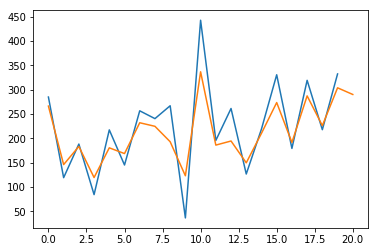

In [10]:
predictions = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_x_train) # yellow line
plt.show()

In [11]:
def show_test_fit():
    output = model.predict(x_test_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_test[i]
        predictions.append(yhat)
    model.reset_states()
    return predictions, origin_x_test

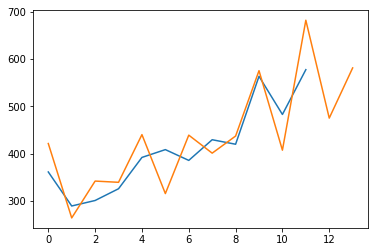

In [12]:
predictions, origin_x_test = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions)
plt.plot(origin_x_test)
plt.show()

## bitcoin data with LSTM

https://www.blockchain.com/ko/charts/market-price?timespan=60days